In [1]:
import torch
import random
from transformers import AutoImageProcessor, TrOCRProcessor

processor_location = AutoImageProcessor.from_pretrained(
    'processor/facebook/detr-resnet-50',
    size={
        'longest_edge': 800,
        'shortest_edge': 800
    })

processor_recognition = TrOCRProcessor.from_pretrained(
    'processor/microsoft/trocr-base-handwritten')

processor_location, processor_recognition

/root/miniconda3/envs/pt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(DetrImageProcessor {
   "do_normalize": true,
   "do_pad": true,
   "do_rescale": true,
   "do_resize": true,
   "format": "coco_detection",
   "image_mean": [
     0.485,
     0.456,
     0.406
   ],
   "image_processor_type": "DetrImageProcessor",
   "image_std": [
     0.229,
     0.224,
     0.225
   ],
   "resample": 2,
   "rescale_factor": 0.00392156862745098,
   "size": {
     "longest_edge": 800,
     "shortest_edge": 800
   }
 },
 TrOCRProcessor:
 - image_processor: ViTImageProcessor {
   "do_normalize": true,
   "do_rescale": true,
   "do_resize": true,
   "image_mean": [
     0.5,
     0.5,
     0.5
   ],
   "image_processor_type": "ViTImageProcessor",
   "image_std": [
     0.5,
     0.5,
     0.5
   ],
   "processor_class": "TrOCRProcessor",
   "resample": 2,
   "rescale_factor": 0.00392156862745098,
   "size": {
     "height": 384,
     "width": 384
   }
 }
 
 - tokenizer: RobertaTokenizerFast(name_or_path='processor/microsoft/trocr-base-handwritten', vocab_size=50265, m

In [2]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
    def forward(self, pixel_values, pixel_mask):
        last_hidden_state = self.model(pixel_values=pixel_values,
                                       pixel_mask=pixel_mask).last_hidden_state

        class_pred = self.class_labels_classifier(last_hidden_state)
        box_pred = self.bbox_predictor(last_hidden_state).sigmoid()

        return class_pred, box_pred


model_location = torch.load('model/文字定位.model').to('cuda')

In [3]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, pixel_values):
        last_hidden_state = self.encoder(pixel_values).last_hidden_state

        input_ids = torch.full([len(pixel_values), 1], 
                               processor_recognition.tokenizer.cls_token_id).to('cuda')
        for i in range(127):
            logits = self.decoder(input_ids=input_ids, 
                                  encoder_hidden_states=last_hidden_state).logits
            logits = logits.argmax(2)[:, -1].unsqueeze(1)
            input_ids = torch.cat([input_ids, logits], 1)

        return input_ids
        
model_recognition = torch.load('model/文字识别.model').to('cuda')

In [4]:
from datasets import load_from_disk

dataset = load_from_disk('dataset/lansinuote/ocr_id_card_small')['train']
dataset = dataset.select(range(500)).remove_columns(['ocr'])

def f(data):
    data['image'] = data['image'].resize([800, 800])
    return data

dataset = dataset.map(f)

dataset, dataset[0]

(Dataset({
     features: ['image'],
     num_rows: 500
 }),
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=800x800>})

In [5]:
%run 2.文字定位Loss函数.ipynb

In [6]:
def location(image):
    data = processor_location(image, return_tensors='pt').to('cuda')

    with torch.no_grad():
        class_pred, box_pred = model_location(data['pixel_values'], data['pixel_mask'])

    class_pred = class_pred.argmax(dim=2)
    box_pred = box_pred[class_pred <= 7][:16]
    class_pred = class_pred[class_pred <= 7][:16]

    box_pred = matcher.xywh_to_x1y1x2y2(box_pred)
    box_pred *= 800

    return class_pred.tolist(), box_pred.tolist()

image = random.choice(dataset)['image']

class_pred, box_pred = location(image)
    
class_pred, box_pred

([2, 5, 1, 3, 0, 6, 7, 4],
 [[336.2998352050781,
   279.62078857421875,
   394.67364501953125,
   354.2447204589844],
  [390.907958984375, 363.0403137207031, 445.79449462890625, 421.4291076660156],
  [148.30206298828125,
   309.244873046875,
   206.9828338623047,
   381.17413330078125],
  [157.38406372070312,
   392.1313171386719,
   261.84283447265625,
   455.0619201660156],
  [137.49395751953125,
   207.9551239013672,
   277.0753479003906,
   292.2454833984375],
  [168.96116638183594,
   431.69927978515625,
   535.9698486328125,
   604.5983276367188],
  [307.6469421386719, 630.78173828125, 700.8572387695312, 747.9359741210938],
  [322.82501220703125,
   375.8153991699219,
   361.2845764160156,
   430.6004638671875]])

In [7]:
import PIL.Image


def recognition(image, box_pred):

    def pad(image):
        w, h = image.size
    
        ratio = 384 / max(w, h)
    
        w = int(ratio * w)
        h = int(ratio * h)
    
        image = image.resize([w, h])
    
        pad = PIL.Image.new('RGB', [384, 384], 'black')
        pad.paste(image, [0, 0])
    
        return pad

    def decode(input_ids):
        input_ids = input_ids.tolist()
    
        if processor_recognition.tokenizer.sep_token_id in input_ids:
            idx = input_ids.index(processor_recognition.tokenizer.sep_token_id) + 1
            input_ids = input_ids[:idx]
    
        return processor_recognition.tokenizer.decode(input_ids, skip_special_tokens=True)

    image = [pad(image.crop(box)) for box in box_pred]
    pixel_values = processor_recognition(image, return_tensors='pt').pixel_values.to('cuda')

    with torch.no_grad():
        logits = model_recognition(pixel_values)
    
    return [decode(i) for i in logits]


text = recognition(image, box_pred)

text

['汉', '24', '女', '1981', '陆梓翰', '内蒙古自治区通辽市奈曼旗', '953251198104245231', '4']

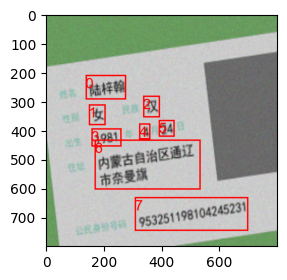

In [8]:
import PIL.ImageDraw
import PIL.ImageFont
from matplotlib import pyplot as plt
import numpy as np


def show(image, box_pred, class_pred):
    font = PIL.ImageFont.truetype('arial.ttf', size=50)
    draw = PIL.ImageDraw.Draw(image)
    for b, c in zip(box_pred, class_pred):
        draw.rectangle(b, outline='red', width=5)
        draw.text(b[:2], str(c), fill='red', font=font)
    
    plt.figure(figsize=[3, 3])
    plt.imshow(image)
    plt.show()


show(image, box_pred, class_pred)

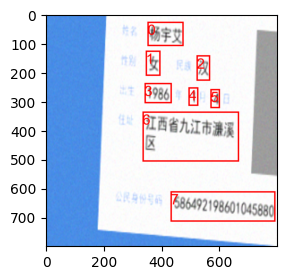

姓名->杨宇艾
性别->女
民族->汉
年->1986
月->1
日->4
住址->江西省九江市濂溪区
号码->586492198601045880


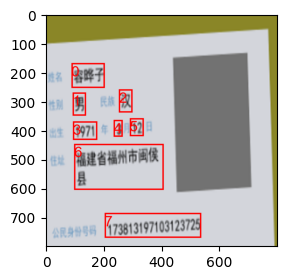

姓名->容晔子
性别->男
民族->汉
年->1971
月->3
日->12
住址->福建省福州市闽侯县
号码->173813197103123725


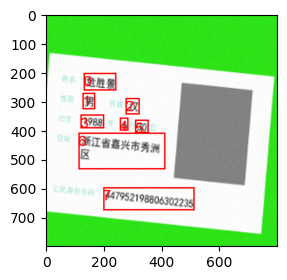

姓名->危胜景
性别->男
民族->汉
年->1988
月->6
日->30
住址->浙江省嘉兴市秀洲区
号码->447952198806302235


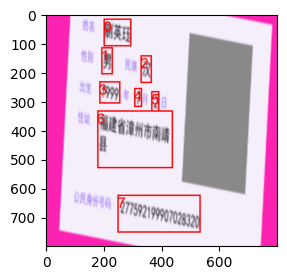

姓名->蒯英珏
性别->男
民族->汉
年->1999
月->7
日->2
住址->福建省漳州市南靖县
号码->277592199907028320


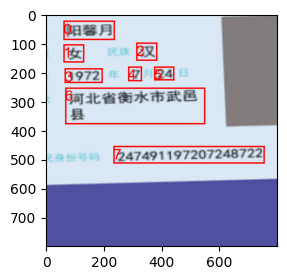

姓名->阳馨月
性别->女
民族->汉
年->1972
月->7
日->24
住址->河北省衡水市武邑县
号码->247491197207248722


In [9]:
for _ in range(5):
    image = random.choice(dataset)['image']
    class_pred, box_pred = location(image)
    text = recognition(image, box_pred)

    show(image, box_pred, class_pred)

    class_name = ['姓名','性别','民族','年','月','日','住址','号码']
    for cls in range(8):
        if cls not in class_pred:
            continue
        idx = class_pred.index(cls)
        print(class_name[cls] + '->' + text[idx])